In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    #total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss*modulating_number
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0616/weights_KD_segformer_0616_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.1
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 6s 585ms/step - loss: 0.0820
Average validation loss: 0.5847513675689697
4/4 [==============================] - 6s 594ms/step - loss: 0.0820 - val_loss: 0.5848
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 8s 578ms/step - loss: 0.0577 - val_loss: 0.5848
Average validation loss: 0.5280871987342834
4/4 [==============================] - 8s 589ms/step - loss: 0.0577 - val_loss: 0.5564
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 10s 577ms/step - loss: 0.0453 - val_loss: 0.5564
Average validation loss: 0.25321799516677856
4/4 [==============================] - 10s 592ms/step - loss: 0.0453 - val_los

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 5s 676ms/step - loss: 5.4683e-05
Average validation loss: 0.0005196984275244176
8/8 [==============================] - 6s 688ms/step - loss: 5.4683e-05 - val_loss: 5.1970e-04
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 11s 691ms/step - loss: 5.1899e-05 - val_loss: 5.1970e-04
Average validation loss: 9.035315451910719e-05
8/8 [==============================] - 11s 700ms/step - loss: 5.1899e-05 - val_loss: 3.0503e-04
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_10.pth'.
Epoch 3/10
8/8 [==============================] - 17s 706ms/step - loss: 5.1347e-05 - val_loss: 3.0503e-04
Average validation loss: 1.847752446337836e-05
8/8 [=========================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 9s 718ms/step - loss: 8.0963e-05
Average validation loss: 0.048356227576732635
12/12 [==============================] - 9s 729ms/step - loss: 8.0963e-05 - val_loss: 0.0484
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 17s 705ms/step - loss: 8.2245e-05 - val_loss: 0.0484
Average validation loss: 0.03778281155973673
12/12 [==============================] - 17s 717ms/step - loss: 8.2245e-05 - val_loss: 0.0431
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_15.pth'.
Epoch 3/10
12/12 [==============================] - 26s 733ms/step - loss: 8.2811e-05 - val_loss: 0.0431
Average validation loss: 0.06951608055309026
12/12 [==============================] - 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 12s 735ms/step - loss: 5.6804e-05
Average validation loss: 0.05356242597179062
16/16 [==============================] - 12s 743ms/step - loss: 5.6804e-05 - val_loss: 0.0536
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 23s 704ms/step - loss: 6.5427e-05 - val_loss: 0.0536
Average validation loss: 0.05552538163829013
16/16 [==============================] - 23s 716ms/step - loss: 6.5427e-05 - val_loss: 0.0545
Epoch 3/10
16/16 [==============================] - 35s 707ms/step - loss: 6.4045e-05 - val_loss: 0.0545
Average validation loss: 0.05770777437464858
16/16 [==============================] - 35s 718ms/step - loss: 6.4045e-05 - val_loss: 0.0556
Epoch 4/10
16/16 [==============================] - 46s 690ms/step - loss: 6.1537e-05 - val_loss: 0.0556
Average validatio

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 15s 758ms/step - loss: 4.1621e-05
Average validation loss: 0.029286766611039638
20/20 [==============================] - 15s 771ms/step - loss: 4.1621e-05 - val_loss: 0.0293
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 31s 765ms/step - loss: 3.8230e-05 - val_loss: 0.0293
Average validation loss: 0.05831290624337271
20/20 [==============================] - 31s 775ms/step - loss: 3.8230e-05 - val_loss: 0.0438
Epoch 3/10
20/20 [==============================] - 47s 781ms/step - loss: 3.9047e-05 - val_loss: 0.0438
Average validation loss: 0.024314800137653948
20/20 [==============================] - 47s 792ms/step - loss: 3.9047e-05 - val_loss: 0.0373
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/we

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 18s 766ms/step - loss: 5.4165e-05
Average validation loss: 0.023843855907519657
24/24 [==============================] - 19s 776ms/step - loss: 5.4165e-05 - val_loss: 0.0238
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 37s 770ms/step - loss: 5.2187e-05 - val_loss: 0.0238
Average validation loss: 0.01993192732334137
24/24 [==============================] - 37s 781ms/step - loss: 5.2187e-05 - val_loss: 0.0219
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 56s 763ms/step - loss: 5.1583e-05 - val_loss: 0.0219
Average validation loss: 0.044308568040529885
24/24 [==============================]

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 30s 760ms/step - loss: 1.0311e-04
Average validation loss: 0.03278380203992128
40/40 [==============================] - 31s 770ms/step - loss: 1.0311e-04 - val_loss: 0.0328
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 61s 758ms/step - loss: 9.3095e-05 - val_loss: 0.0328
Average validation loss: 0.04101285245269537
40/40 [==============================] - 62s 768ms/step - loss: 9.3095e-05 - val_loss: 0.0369
Epoch 3/10
40/40 [==============================] - 92s 762ms/step - loss: 8.7819e-05 - val_loss: 0.0369
Average validation loss: 0.02665008082985878
40/40 [==============================] - 93s 772ms/step - loss: 8.7819e-05 - val_loss: 0.0335
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weig

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 37s 762ms/step - loss: 7.9921e-05
Average validation loss: 0.0411742105037168
48/48 [==============================] - 37s 774ms/step - loss: 7.9921e-05 - val_loss: 0.0412
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 74s 768ms/step - loss: 6.7782e-05 - val_loss: 0.0412
Average validation loss: 0.03168800345156342
48/48 [==============================] - 75s 779ms/step - loss: 6.7782e-05 - val_loss: 0.0364
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_60.pth'.
Epoch 3/10
48/48 [==============================] - 112s 767ms/step - loss: 5.9726e-05 - val_loss: 0.0364
Average validation loss: 0.02517140699395289
48/48 [==============================] -

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 40s 710ms/step - loss: 8.3491e-05
Average validation loss: 0.05502293855949704
56/56 [==============================] - 40s 720ms/step - loss: 8.3491e-05 - val_loss: 0.0550
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 80s 712ms/step - loss: 6.4689e-05 - val_loss: 0.0550
Average validation loss: 0.02506944059444192
56/56 [==============================] - 81s 722ms/step - loss: 6.4689e-05 - val_loss: 0.0400
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_70.pth'.
Epoch 3/10
56/56 [==============================] - 120s 697ms/step - loss: 5.5516e-05 - val_loss: 0.0400
Average validation loss: 0.02772711739609284
56/56 [==============================] 

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 46s 717ms/step - loss: 5.5402e-05
Average validation loss: 0.04929189247195609
64/64 [==============================] - 47s 727ms/step - loss: 5.5402e-05 - val_loss: 0.0493
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 91s 699ms/step - loss: 4.1813e-05 - val_loss: 0.0493
Average validation loss: 0.018066539079882205
64/64 [==============================] - 92s 709ms/step - loss: 4.1813e-05 - val_loss: 0.0337
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 138s 715ms/step - loss: 3.4172e-05 - val_loss: 0.0337
Average validation loss: 0.01629797971691005
64/64 [==============================]

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 51s 706ms/step - loss: 3.8071e-05
Average validation loss: 0.028735077784707148
72/72 [==============================] - 52s 716ms/step - loss: 3.8071e-05 - val_loss: 0.0287
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 102s 703ms/step - loss: 2.6412e-05 - val_loss: 0.0287
Average validation loss: 0.014040622109961178
72/72 [==============================] - 103s 713ms/step - loss: 2.6412e-05 - val_loss: 0.0214
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_90.pth'.
Epoch 3/10
72/72 [==============================] - 154s 711ms/step - loss: 2.1385e-05 - val_loss: 0.0214
Average validation loss: 0.017639916131479874
72/72 [===========================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 56s 697ms/step - loss: 4.1066e-05
Average validation loss: 0.020960746379569174
80/80 [==============================] - 57s 707ms/step - loss: 4.1066e-05 - val_loss: 0.0210
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 113s 702ms/step - loss: 2.8468e-05 - val_loss: 0.0210
Average validation loss: 0.016220902418717743
80/80 [==============================] - 113s 712ms/step - loss: 2.8468e-05 - val_loss: 0.0186
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_100.pth'.
Epoch 3/10
80/80 [==============================] - 169s 698ms/step - loss: 2.2637e-05 - val_loss: 0.0186
Average validation loss: 0.025437439139932395
80/80 [=========================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 69s 716ms/step - loss: 6.8220e-05
Average validation loss: 0.02990800675858433
96/96 [==============================] - 70s 727ms/step - loss: 6.8220e-05 - val_loss: 0.0299
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 137s 697ms/step - loss: 5.1389e-05 - val_loss: 0.0299
Average validation loss: 0.02689986578479875
96/96 [==============================] - 138s 707ms/step - loss: 5.1389e-05 - val_loss: 0.0284
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 205s 704ms/step - loss: 4.1193e-05 - val_loss: 0.0284
Average validation loss: 0.02890112014877862
96/96 [============================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 85s 710ms/step - loss: 4.3079e-05
Average validation loss: 0.0183706808835268
120/120 [==============================] - 86s 719ms/step - loss: 4.3079e-05 - val_loss: 0.0184
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 171s 704ms/step - loss: 2.9720e-05 - val_loss: 0.0184
Average validation loss: 0.01167024226548771
120/120 [==============================] - 172s 713ms/step - loss: 2.9720e-05 - val_loss: 0.0150
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 257s 709ms/step - loss: 2.3063e-05 - val_loss: 0.0150
Average validation loss: 0.010570290700222055
120/120 [================

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 102s 705ms/step - loss: 3.7737e-05
Average validation loss: 0.013471650528824992
144/144 [==============================] - 103s 715ms/step - loss: 3.7737e-05 - val_loss: 0.0135
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 204s 703ms/step - loss: 2.5760e-05 - val_loss: 0.0135
Average validation loss: 0.013258237430515388
144/144 [==============================] - 206s 713ms/step - loss: 2.5760e-05 - val_loss: 0.0134
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_180.pth'.
Epoch 3/10
144/144 [==============================] - 307s 700ms/step - loss: 2.0261e-05 - val_loss: 0.0134
Average validation loss: 0.017133349662698392
144/144 [===========

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 113s 708ms/step - loss: 2.2473e-05
Average validation loss: 0.018246838271443265
160/160 [==============================] - 115s 718ms/step - loss: 2.2473e-05 - val_loss: 0.0182
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 227s 702ms/step - loss: 1.7861e-05 - val_loss: 0.0182
Average validation loss: 0.062061995622298124
160/160 [==============================] - 229s 712ms/step - loss: 1.7861e-05 - val_loss: 0.0402
Epoch 3/10
160/160 [==============================] - 342s 704ms/step - loss: 1.4777e-05 - val_loss: 0.0402
Average validation loss: 0.0097762349905679
160/160 [==============================] - 343s 714ms/step - loss: 1.4777e-05 - val_loss: 0.0300
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 143s 716ms/step - loss: 7.4635e-05
Average validation loss: 0.01714780687005259
200/200 [==============================] - 145s 726ms/step - loss: 7.4635e-05 - val_loss: 0.0171
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 288s 715ms/step - loss: 5.2111e-05 - val_loss: 0.0171
Average validation loss: 0.014571214304305613
200/200 [==============================] - 290s 725ms/step - loss: 5.2111e-05 - val_loss: 0.0159
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 434s 718ms/step - loss: 3.9781e-05 - val_loss: 0.0159
Average validation loss: 0.016872711381874978
200/200 [============

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:48 - loss: 4.1006e-05

c:\Users\user\anaconda3\envs\sam_trial\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 172s 717ms/step - loss: 2.7843e-05
Average validation loss: 0.018183134296365703
240/240 [==============================] - 174s 727ms/step - loss: 2.7843e-05 - val_loss: 0.0182
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 346s 715ms/step - loss: 2.0028e-05 - val_loss: 0.0182
Average validation loss: 0.013093685228886898
240/240 [==============================] - 348s 725ms/step - loss: 2.0028e-05 - val_loss: 0.0156
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\ar2DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_10\segformer_data_size_300.pth'.
Epoch 3/10
240/240 [==============================] - 520s 713ms/step - loss: 1.6696e-05 - val_loss: 0.0156
Average validation loss: 0.013636749505212719
240/240 [===========

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.049343781760962886, 0.05180384130282533, 0.07157732820497838, 0.042893382938234484, 0.0540710947036057, 0.024194040668323095, 0.03373499007703322, 0.03862924498099043, 0.030524926057787526, 0.03189815656545534, 0.01877136244031135, 0.023241640277564982, 0.020796153296129584, 0.021598119067197937, 0.015213350562278138, 0.014203890696491384, 0.012885998514869969, 0.012267359633671997]
std_val_losses =  [0.11333090390593338, 0.04966522269109412, 0.07629351866485354, 0.03786749610104418, 0.07018589670259526, 0.015978804490783906, 0.016490235736132352, 0.020406935701418466, 0.03107621387231306, 0.04881835237520008, 0.015403732165962532, 0.022946924076561993, 0.008335292122882997, 0.01988047679737424, 0.008998416411222144, 0.01555397319397134, 0.010045173448787682, 0.00798388101257528]


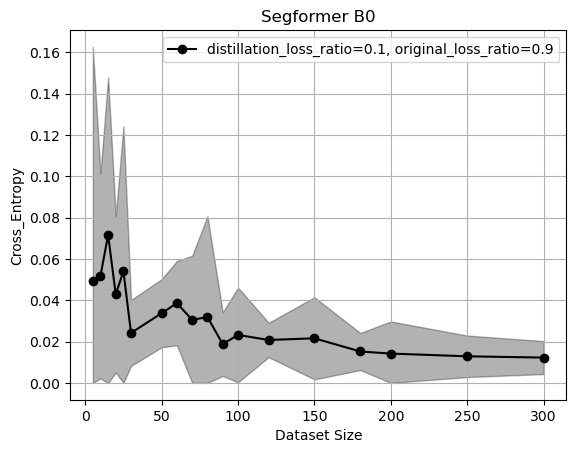

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0616')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.png"))

plt.show()